## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [133]:
import matplotlib.pylab as plt

In [1]:
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *

# Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32
n_iters = 5000

# Load data

In [3]:
bulk_anndata_path = "/home/jupyter/mb-ml-data-disk/temporal-rna-seq-deconvolution/ebov_bulk.h5ad"
sc_anndata_path = "/home/jupyter/mb-ml-data-disk/temporal-rna-seq-deconvolution/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0 
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'single_cell_od' #'overdispersed_bulk'
)

## `trajectories.py`

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot
from torch.distributions import constraints
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from typing import List, Dict
import pyro.distributions as dist
import anndata
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
import tqdm
import copy
from matplotlib.pyplot import cm
import pandas as pd
import seaborn as sns
import time
import scanpy as sc

from ternadecov.stats_helpers import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.hypercluster import *
from ternadecov.dataset import *


class BasicTrajectoryModule:
    def __init__(
        self,
        basis_functions: str,
        polynomial_degree: int,
        num_cell_types: int,
        num_samples: int,
        init_posterior_global_scale_factor: float,
        device: torch.device,
        dtype: torch.dtype,
    ):
        self.device = device
        self.dtype = dtype
        self.polynomial_degree = polynomial_degree
        self.basis_functions = basis_functions
        self.num_cell_types = num_cell_types
        self.num_samples = num_samples
        self.init_posterior_global_scale_factor = init_posterior_global_scale_factor

        #####################################################
        ## Prior
        #####################################################
        self.unnorm_cell_pop_base_prior_loc_c = np.zeros((self.num_cell_types,))
        self.unnorm_cell_pop_base_prior_scale_c = np.ones((self.num_cell_types,))

        # dist of coefficients of population deformation polynomial
        self.unnorm_cell_pop_deform_prior_loc_ck = np.zeros(
            (self.num_cell_types, self.polynomial_degree)
        )
        self.unnorm_cell_pop_deform_prior_scale_ck = np.ones(
            (self.num_cell_types, self.polynomial_degree)
        )

        # Per sample celltype proportions
        self.cell_pop_prior_loc_cm = (
            np.ones((self.num_cell_types, self.num_samples)) / self.num_cell_types
        )

        # Dirichlet_alpha prior
        self.dirichlet_alpha_prior = np.ones((1,)) * 1e5

        #####################################################
        ## Posterior
        #####################################################

        self.unnorm_cell_pop_base_posterior_loc_c = np.zeros((self.num_cell_types,))
        self.unnorm_cell_pop_base_posterior_scale_c = (
            self.init_posterior_global_scale_factor * np.ones((self.num_cell_types,))
        )

        self.unnorm_cell_pop_deform_posterior_loc_ck = np.zeros(
            (self.num_cell_types, self.polynomial_degree)
        )
        self.unnorm_cell_pop_deform_posterior_scale_ck = (
            self.init_posterior_global_scale_factor
            * np.ones((self.num_cell_types, self.polynomial_degree))
        )

        self.cell_pop_posterior_loc_mc = (
            self.init_posterior_global_scale_factor
            * np.ones((self.num_samples, self.num_cell_types))
            / self.num_cell_types
        )

    def model(self, t_m: torch.Tensor):

        # sample unnorm_cell_pop_base_c
        unnorm_cell_pop_base_c = pyro.sample(
            "unnorm_cell_pop_base_c",
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_base_prior_loc_c,
                    device=self.device,
                    dtype=self.dtype,
                ),
                scale=torch.tensor(
                    self.unnorm_cell_pop_base_prior_scale_c,
                    device=self.device,
                    dtype=self.dtype,
                ),
            ).to_event(1),
        )
        assert unnorm_cell_pop_base_c.shape == (self.num_cell_types,)

        # Deformation scale is a learnable parameter now
        unnorm_cell_pop_deform_prior_scale_ck = pyro.param(
            "unnorm_cell_pop_deform_prior_scale_ck",
            torch.tensor(
                self.unnorm_cell_pop_deform_prior_scale_ck,
                device=self.device,
                dtype=self.dtype,
            ),
            constraint=constraints.positive,
        )
        assert unnorm_cell_pop_deform_prior_scale_ck.shape == (
            self.num_cell_types,
            self.polynomial_degree,
        )

        unnorm_cell_pop_deform_ck = pyro.sample(
            "unnorm_cell_pop_deform_ck",
            dist.Normal(
                loc=torch.tensor(
                    self.unnorm_cell_pop_deform_prior_loc_ck,
                    device=self.device,
                    dtype=self.dtype,
                ),
                scale=unnorm_cell_pop_deform_prior_scale_ck,
            ).to_event(2),
        )
        assert unnorm_cell_pop_deform_ck.shape == (
            self.num_cell_types,
            self.polynomial_degree,
        )

        dirichlet_alpha = pyro.param(
            "dirichlet_alpha",
            torch.tensor(
                self.dirichlet_alpha_prior, device=self.device, dtype=self.dtype,
            ),
            constraint=constraints.positive,
        )
        assert dirichlet_alpha.shape == (1,)

        if self.basis_functions == "polynomial":
            tau_km = torch.pow(
                t_m[None, :],
                torch.arange(1, self.polynomial_degree + 1, device=self.device)[
                    :, None
                ],
            )
            deformation_mc = torch.matmul(unnorm_cell_pop_deform_ck, tau_km).transpose(
                -1, -2
            )
        elif self.basis_functions == "legendre":
            # l -- power of the term of the legrenre polynomial
            t_m_prime = 2 * t_m - 1  # discrete times in (-1,1)
            t_lm = torch.pow(
                t_m_prime[None, :],
                torch.arange(0, self.polynomial_degree + 1, device=self.device)[
                    :, None
                ],
            )
            c_kl = legendre_coefficient_mat(self.polynomial_degree, dtype=dtype)[
                1:,
            ].to(
                device
            )  # drop constant term
            intermediate_legenre_vals_km = torch.matmul(c_kl, t_lm)
            deformation_mc = torch.matmul(
                unnorm_cell_pop_deform_ck, intermediate_legenre_vals_km
            ).transpose(-1, -2)

        # The normalized underlying trajectories, serve as Dirichlet params
        trajectory_mc = torch.nn.functional.softmax(
            unnorm_cell_pop_base_c[None, :] + deformation_mc, dim=-1
        )

        per_sample_draw = True
        if per_sample_draw:
            # dirichlet_alpha = torch.tensor([1e4], device=self.device)
            dirichlet_dist = dist.Dirichlet(
                concentration=trajectory_mc * dirichlet_alpha
            ).to_event(1)

            cell_pop_mc = pyro.sample("cell_pop_mc", dirichlet_dist)
        else:
            cell_pop_mc = trajectory_mc

        assert cell_pop_mc.shape == (self.num_samples, self.num_cell_types,)

        return cell_pop_mc

    def guide(self):

        # variational parameters for unnorm_cell_pop_base_c ("B_c")
        unnorm_cell_pop_base_posterior_loc_c = pyro.param(
            "unnorm_cell_pop_base_posterior_loc_c",
            torch.tensor(
                self.unnorm_cell_pop_base_posterior_loc_c,
                device=self.device,
                dtype=self.dtype,
            ),
        )

        # variational parameters for unnorm_cell_pop_deform_c ("R_c")
        unnorm_cell_pop_deform_posterior_loc_ck = pyro.param(
            "unnorm_cell_pop_deform_posterior_loc_ck",
            torch.tensor(
                self.unnorm_cell_pop_deform_posterior_loc_ck,
                device=self.device,
                dtype=self.dtype,
            ),
        )

        # Cell composition
        #         new_code = False
        #         if new_code:
        #              cell_pop_unconstrained_posterior_loc_mc = pyro.param(
        #                 "cell_pop_unconstrained_posterior_loc_mc",
        #                 torch.tensor(
        #                     self.cell_pop_posterior_loc_mc,
        #                     device=self.device,
        #                     dtype=self.dtype,
        #                 ),
        #                 constraint=constraints.simplex,
        #             )
        #             epsilon = 1e-6
        #             # This is on a simplex
        #             cell_pop_posterior_loc_mc = epsilon / self.cell_pop_posterior_loc_mc.shape[-1] +
        #                 (1-epsilon) * cell_pop_unconstrained_posterior_loc_mc
        #         else:
        cell_pop_posterior_loc_mc = pyro.param(
            "cell_pop_posterior_loc_mc",
            torch.tensor(
                self.cell_pop_posterior_loc_mc, device=self.device, dtype=self.dtype,
            ),
            constraint=constraints.simplex,
        )

        unnorm_cell_pop_base_c = pyro.sample(
            "unnorm_cell_pop_base_c",
            dist.Delta(v=unnorm_cell_pop_base_posterior_loc_c).to_event(1),
        )

        unnorm_cell_pop_deform_ck = pyro.sample(
            "unnorm_cell_pop_deform_ck",
            dist.Delta(v=unnorm_cell_pop_deform_posterior_loc_ck).to_event(2),
        )

        cell_pop_mc = pyro.sample(
            "cell_pop_mc", dist.Delta(v=cell_pop_posterior_loc_mc).to_event(2),
        )

    def calculate_composition_trajectories(
        self, dataset, n_intervals=100, return_vals=False
    ):
        """Calculate the composition trajectories"""
        # calculate true times
        if self.basis_functions == "polynomial":
            time_step = 1 / n_intervals
            times_z = torch.arange(0, 1, time_step)
            # Take time to appropriate exponent
            times_zk = torch.pow(
                times_z[:, None], torch.arange(1, self.polynomial_degree + 1,),
            )
            # get the trained params
            base_composition_post_c = (
                pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
            )
            delta_composition_post_ck = (
                pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()
            )
            # Calculate the deltas for each time point
            delta_cz = torch.matmul(
                delta_composition_post_ck, times_zk.transpose(-1, -2)
            )
            # normalize
            norm_comp_tc = (
                torch.nn.functional.softmax(
                    base_composition_post_c[:, None] + delta_cz, dim=0
                )
                .numpy()
                .T
            )
            true_times_z = times_z * dataset.time_range + dataset.time_min
        elif self.basis_functions == "legendre":
            time_step = 2 / n_intervals
            times_z = torch.arange(-1, 1, time_step)
            # Take time to appropriate exponent
            times_zk = torch.pow(
                times_z[:, None], torch.arange(1, self.polynomial_degree + 1,),
            )
            # get the trained params
            base_composition_post_c = (
                pyro.param("unnorm_cell_pop_base_posterior_loc_c").detach().cpu()
            )
            delta_composition_post_ck = (
                pyro.param("unnorm_cell_pop_deform_posterior_loc_ck").detach().cpu()
            )
            # Calculate the deltas for each time point
            delta_cz = torch.matmul(
                delta_composition_post_ck, times_zk.transpose(-1, -2)
            )
            # normalize
            norm_comp_tc = (
                torch.nn.functional.softmax(
                    base_composition_post_c[:, None] + delta_cz, dim=0
                )
                .numpy()
                .T
            )
            true_times_z = ((times_z + 1) / 2) * dataset.time_range + dataset.time_min

        norm_comp_ct_torch = torch.Tensor(norm_comp_tc).T
        summarized_composition_rt = None
        toplevel_cell_map = None
        if dataset.is_hyperclustered:
            cluster_map = dataset.hypercluster_results["cluster_map"]
            toplevel_cell_map = {
                ct: i for i, ct in enumerate({cluster_map[k] for k in cluster_map})
            }
            summarized_num_cells = len(toplevel_cell_map)
            summarized_composition_rt = torch.zeros(
                (summarized_num_cells, norm_comp_tc.shape[0])
            )

            for c_index in range(0, norm_comp_ct_torch.shape[0] - 1):
                low_cluster_name = dataset.cell_type_str_list[c_index]
                top_cluster_name = cluster_map[low_cluster_name]
                summarized_composition_rt[toplevel_cell_map[top_cluster_name]].add_(
                    norm_comp_ct_torch[c_index,]
                )

        self.calculated_trajectories = {
            "times_z": times_z.numpy(),
            "true_times_z": true_times_z,
            "norm_comp_tc": norm_comp_tc,  # These are the trajectories on the native clusters
            "summarized_composition_rt": summarized_composition_rt,  # These are the trajectories on the summarized results
            "toplevel_cell_map": toplevel_cell_map,
        }

        if return_vals:
            return self.calculated_trajectories

In [117]:
from pyro.contrib.gp.models import VariationalSparseGP, VariationalGP
from pyro.nn.module import PyroParam, pyro_method
import pyro.contrib.gp.kernels as kernels
from pyro.contrib.gp.parameterized import Parameterized

from abc import abstractmethod


class TrajectoryModule(Parameterized):
    """The base class of all trajectory modules."""
    
    def __init__(self):
        super(TrajectoryModule, self).__init__()
        
    
    @abstractmethod
    def model(self, xi_mq: torch.Tensor) -> torch.Tensor:
        """TBW."""
        raise NotImplementedError
        
    @abstractmethod
    def guide(self, xi_mq: torch.Tensor) -> torch.Tensor:
        """TBW."""
        raise NotImplementedError
    
    

class VSGPTrajectoryModule(TrajectoryModule):

    def __init__(
            self,
            xi_mq: torch.Tensor,
            num_cell_types: int,
            init_posterior_global_scale_factor: float,
            device: torch.device,
            dtype: torch.dtype,
        ):
        """TBW.
        
        :param xi_mq: covariate tensor with shape (num_sample, covariate_n_dim)
        
        .. note:: in the current model where the only covairate is time, covariate_n_dim == 1
        
        .. note:: The Gaussian process is specifying a function in a (num_cell_types)-dimensional
          unconstrained Euclidean space. Applying softmax to this function give us the normalized
          cell populations on the (num_cell_types)-dimensional simplex. We refer to the unnormalized
          function as "f" for brevity in the code.
          
        """
        super(VSGPTrajectoryModule, self).__init__()
        
        self.xi_mq = xi_mq
        self.num_cell_types = num_cell_types
        self.init_posterior_global_scale_factor = init_posterior_global_scale_factor
        self.device = device
        self.dtype = dtype
        
        assert xi_mq.ndim == 2
        self.num_samples, self.covariate_n_dim = xi_mq.shape
        
        # todo: pull up to __init__ signature
        self.num_inducing_points = 10
        self.init_rbf_kernel_lengthscale = 0.5
        self.init_rbf_kernel_variance = 0.5
        self.init_whitenoise_kernel_variance = 0.1
        self.gp_cholesky_jitter = 1e-4
        
        #####################################################
        ## Prior
        #####################################################

        # kernel setup
        kernel_rbf = kernels.RBF(
            input_dim=self.covariate_n_dim,
            variance=torch.tensor(self.init_rbf_kernel_variance, device=device, dtype=dtype),
            lengthscale=torch.tensor(self.init_rbf_kernel_lengthscale, device=device, dtype=dtype))
        kernel_whitenoise = kernels.WhiteNoise(
            input_dim=self.covariate_n_dim,
            variance=torch.tensor(self.init_whitenoise_kernel_variance, device=device, dtype=dtype))
        kernel_full = kernels.Sum(kernel_rbf, kernel_whitenoise)

        # mean output
        self.gp_f_mean_c = PyroParam(
            torch.zeros((self.num_cell_types,), device=device, dtype=dtype))

        def f_mean_function(xi_nq: torch.Tensor):
            """Takes the covariate tensor with shape (batch_size, covariate_n_dim) and returns the function
            mean with shape (num_cell_types, batch_size).
            
            .. note: the shape of the output of GP is permuted.
            """
            assert xi_nq.ndim == 2
            assert xi_nq.shape[-1] == self.covariate_n_dim
            batch_size = xi_nq.shape[0]
            return self.gp_f_mean_c[..., None].expand([self.num_cell_types, batch_size])

        # initial position for the inducing points
        x_mean, x_std = torch.mean(self.xi_mq).item(), torch.std(self.xi_mq).item()
        self.Xu_init = x_mean + x_std * torch.randn(
            self.num_inducing_points, self.covariate_n_dim,
            device=device, dtype=dtype)

        # instantiate VSGP model
        self.gp = VariationalGP(
            X=xi_mq,
            y=None,
            kernel=kernel_full,
#             Xu=self.Xu_init,
#             num_data=self.num_samples,
            likelihood=None,
            mean_function=f_mean_function,
            latent_shape=torch.Size([self.num_cell_types]),
            whiten=True,
            jitter=self.gp_cholesky_jitter)
        
        #####################################################
        ## Posterior
        #####################################################

        self.gp_init_f_posterior_loc_mc = torch.zeros(
            (self.num_samples, self.num_cell_types), device=device, dtype=dtype)

    @pyro_method
    def model(self, xi_mq: torch.Tensor) -> torch.Tensor:
        self.set_mode("model")
        
        # assert that covariates have the same shape as what given to the initializer
        assert xi_mq.shape == (self.num_samples, self.covariate_n_dim)
        
        # sample the inducing points (this happens implicitly in the model() call to gp)
        self.gp.set_data(X=xi_mq, y=None)
        f_loc_cm, f_var_cm = self.gp.model()
                
        assert f_loc_cm.shape == (self.num_cell_types, self.num_samples)
        assert f_var_cm.shape == (self.num_cell_types, self.num_samples)
        
        # permute the indices and var -> std
        f_loc_mc = f_loc_cm.permute(-1, -2)
        f_scale_mc = f_var_cm.sqrt().permute(-1, -2)

        with pyro.plate("batch"):
            f_mc = pyro.sample(
                "f_mc",
                pyro.distributions.Normal(
                    loc=f_loc_mc,
                    scale=f_scale_mc).to_event(1))

        # finally, apply a softmax to bring the unnormalized cell population ("f) inside
        # the simplex
        cell_pop_mc = torch.softmax(f_mc, -1)
        assert cell_pop_mc.shape == (self.num_samples, self.num_cell_types)

        return cell_pop_mc

    @pyro_method
    def guide(self, xi_mq: torch.Tensor) -> torch.Tensor:
        self.set_mode("guide")

        # sample the posterior of the inducing points (happens implicitly inside the guide() call of gp)
        self.gp.guide()
        
        # sample the posterior of the unnormalized cell population ("f)
        f_posterior_loc_mc = pyro.param(
            "f_posterior_loc_mc",
            self.gp_init_f_posterior_loc_mc)
        with pyro.plate("batch"):
            f_mc = pyro.sample(
                "f_mc",
                pyro.distributions.Delta(v=f_posterior_loc_mc).to_event(1))

        # finally, apply a softmax to bring the unnormalized cell population ("f) inside
        # the simplex
        cell_pop_mc = torch.softmax(f_mc, -1)
        assert cell_pop_mc.shape == (self.num_samples, self.num_cell_types)

        return cell_pop_mc
    
    def calculate_composition_trajectories(
            self, dataset, n_intervals=100, return_vals=False
        ):
        """Calculate the composition trajectories"""
        raise NotImplementedError

In [118]:
traj = VSGPTrajectoryModule(
    xi_mq=ebov_dataset.t_m[..., None].contiguous(),
    num_cell_types=ebov_dataset.num_cell_types,
    init_posterior_global_scale_factor=0.1,
    device=ebov_dataset.device,
    dtype=dtype)

## `time_deconv.py`

In [119]:
import numpy as np
import matplotlib
import matplotlib.pyplot
from torch.distributions import constraints
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from typing import List, Dict
import pyro.distributions as dist
import anndata
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math
import tqdm
import copy
from matplotlib.pyplot import cm
import pandas as pd
import seaborn as sns
import time
import scanpy as sc

from ternadecov.stats_helpers import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.hypercluster import *
from ternadecov.dataset import *
from ternadecov.trajectories import *

# Indices:
# - c cell type
# - g genes
# - m samples
# - k deformation polynomial degree


def generate_batch(
    dataset: DeconvolutionDataset, device: torch.device, dtype: torch.dtype
):

    return {
        "x_mg": dataset.bulk_raw_gex_mg.clone().detach().to(device).type(dtype),
        "t_m": torch.tensor(dataset.dpi_time_m, device=device, dtype=dtype),
    }



_TRAJECTORY_MODEL_TYPES = {'polynomial', 'gp'}


class TimeRegularizedDeconvolution:
    def __init__(
            self,
            dataset: DeconvolutionDataset,
            device: torch.device,
            dtype: torch.dtype,
            use_betas: bool = True,
            trajectory_model_type: str = 'polynomial',
            **kwargs
        ):

        self.dataset = dataset
        self.device = device
        self.dtype = dtype
        self.use_betas = use_betas

        self.init_posterior_global_scale_factor = 0.05

        # hyperparameters
        self.log_beta_prior_scale = 1.0
        self.tau_prior_scale = 1.0
        self.log_phi_prior_loc = -5.0
        self.log_phi_prior_scale = 1.0

        assert trajectory_model_type in _TRAJECTORY_MODEL_TYPES
        
        if trajectory_model_type == 'polynomial':          
            raise NotImplementedError
#             self.population_proportion_model = BasicTrajectoryModule(
#                 basis_functions=kwargs['basis_functions'],
#                 polynomial_degree=kwargs['polynomial_degree'],
#                 num_cell_types=self.dataset.num_cell_types,
#                 num_samples=self.dataset.num_samples,
#                 init_posterior_global_scale_factor=self.init_posterior_global_scale_factor,
#                 device=device,
#                 dtype=dtype)
            
        elif trajectory_model_type == 'gp':
            self.population_proportion_model = VSGPTrajectoryModule(
                xi_mq=self.dataset.t_m[..., None].contiguous(),
                num_cell_types=self.dataset.num_cell_types,
                init_posterior_global_scale_factor=self.init_posterior_global_scale_factor,
                device=device,
                dtype=dtype)
            
        else:
            raise ValueError

        #####################################################
        ## Prior
        #####################################################

        #####################################################
        ## Posterior
        #####################################################

        self.log_beta_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.tau_posterior_scale = 1.0 * self.init_posterior_global_scale_factor
        self.log_phi_posterior_loc = -5.0
        self.log_phi_posterior_scale = 0.1 * self.init_posterior_global_scale_factor

#         self.dirichlet_alpha_posterior = (
#             self.init_posterior_global_scale_factor * np.ones((1,))
#         )

        # cache useful tensors
        self.w_hat_gc = torch.tensor(self.dataset.w_hat_gc, device=device, dtype=dtype)

    def model(
            self,
            x_mg: torch.Tensor,
            t_m: torch.Tensor,
        ):
        """Main model

        :param x_mg: gene expression
        :param t_m: obseration time
        """

        # sample log_phi_g
        log_phi_g = pyro.sample(
            "log_phi_g",
            dist.Normal(
                loc=self.log_phi_prior_loc
                * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype
                ),
                scale=self.log_phi_prior_scale
                * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype
                ),
            ).to_event(1),
        )
        assert log_phi_g.shape == (self.dataset.num_genes,)

        # sample log_beta_g
        log_beta_g = pyro.sample(
            "log_beta_g",
            dist.Normal(
                loc=torch.zeros(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype
                ),
                scale=self.log_beta_prior_scale
                * torch.ones(
                    (self.dataset.num_genes,), device=self.device, dtype=self.dtype
                ),
            ).to_event(1),
        )
        assert log_beta_g.shape == (self.dataset.num_genes,)

        # calculate useful derived variables
        beta_g = log_beta_g.exp()
        phi_g = log_phi_g.exp()

        # Get normalized w_gc
        if self.use_betas:
            unnorm_w_gc = self.w_hat_gc * beta_g[:, None]
        else:
            unnorm_w_gc = self.w_hat_gc

        w_gc = unnorm_w_gc / unnorm_w_gc.sum(0)

        # get the prior cell populations from the trajectory module
        cell_pop_mc = self.population_proportion_model.model(
            xi_mq=t_m[..., None].contiguous()
        )

        # calculate mean gene expression
        mu_mg = x_mg.sum(-1)[:, None] * torch.matmul(
            cell_pop_mc, w_gc.transpose(-1, -2)
        )

        with pyro.plate("batch"):
            # observe gene expression
            # todo: sample specific phi?
            pyro.sample(
                "x_mg",
                NegativeBinomialAltParam(mu=mu_mg, phi=phi_g[None, :]).to_event(1),
                obs=x_mg,
            )

    def delta_guide(self, x_mg: torch.Tensor, t_m: torch.Tensor):
        """Simple delta guide"""

        # variational parameters for log_phi_g
        log_phi_posterior_loc_g = pyro.param(
            "log_phi_posterior_loc_g",
            self.log_phi_posterior_loc
            * torch.ones(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype
            ),
        )

        # variational parameters for log_beta_g
        log_beta_posterior_loc_g = pyro.param(
            "log_beta_posterior_loc_g",
            torch.zeros(
                (self.dataset.num_genes,), device=self.device, dtype=self.dtype
            ),
        )

        # posterior sample statements
        log_phi_g = pyro.sample(
            "log_phi_g", dist.Delta(v=log_phi_posterior_loc_g).to_event(1)
        )

        log_beta_g = pyro.sample(
            "log_beta_g", dist.Delta(v=log_beta_posterior_loc_g).to_event(1)
        )

        # get the posterior cell populations from the trajectory module
        cell_pop_mc = self.population_proportion_model.guide(
            xi_mq=t_m[..., None].contiguous()
        )

    def fit_model(
            self,
            n_iters=3000,
            log_frequency=100,
            verbose=True,
            clear_param_store=True,
            keep_param_store_history=True,
        ):
        if clear_param_store:
            pyro.clear_param_store()

        ## TODO: bring these out
        optim = pyro.optim.Adam({"lr": 1e-3})

        self.loss_hist = []
        self.param_store_hist = []

        svi = SVI(
            model=self.model, guide=self.delta_guide, optim=optim, loss=Trace_ELBO()
        )

        start_time = time.time()
        for i_iter in range(n_iters):
            batch_dict = generate_batch(self.dataset, self.device, self.dtype)

            loss = svi.step(**batch_dict)
            self.loss_hist.append(loss)

            if keep_param_store_history:
                param_store = pyro.get_param_store()
                self.param_store_hist.append(
                    {
                        k: v.detach().float().cpu().clone()
                        for k, v in param_store.items()
                    }
                )

            if verbose:
                if i_iter % log_frequency == 0:

                    print(
                        f"[step: {i_iter}, time: {math.ceil(time.time() - start_time)} s ] loss: {self.loss_hist[-1]:.2f}"
                    )

    def plot_loss(self):
        """Plot the losses during training"""
        fig, ax = matplotlib.pyplot.subplots()
        ax.plot(self.loss_hist)
        ax.set_title("Losses")
        ax.set_xlabel("iteration")
        ax.set_ylabel("ELBO Loss")

        return ax

    def calculate_composition_trajectories(self, n_intervals=100, return_vals=False):
        self.population_proportion_model.calculate_composition_trajectories(
            self.dataset, n_intervals=100, return_vals=False
        )

    def get_composition_trajectories(self):
        """Return the composition trajectories"""
        return self.population_proportion_model.calculated_trajectories

    def plot_composition_trajectories(self, show_hypercluster=False):
        """Plot the composition trajectories"""

        if self.dataset.is_hyperclustered and not show_hypercluster:
            fig, ax = matplotlib.pyplot.subplots()
            ax.plot(
                self.calculated_trajectories["true_times_z"],
                self.calculated_trajectories["summarized_composition_rt"].T,
            )
            ax.set_title("Predicted cell proportions")
            ax.set_xlabel("Time")

            labels = []

            r = self.calculated_trajectories["toplevel_cell_map"]
            map_r = {r[k]: k for k in r}
            for i in range(len(map_r)):
                labels.append(map_r[i])
            ax.legend(labels, loc="best", fontsize="small")
        else:
            fig, ax = matplotlib.pyplot.subplots()
            ax.plot(
                self.population_proportion_model.calculated_trajectories[
                    "true_times_z"
                ],
                self.population_proportion_model.calculated_trajectories[
                    "norm_comp_tc"
                ],
            )
            ax.set_title("Predicted cell proportions")
            ax.set_xlabel("Time")
            ax.legend(self.dataset.cell_type_str_list, loc="best", fontsize="small")

    def plot_phi_g_distribution(self):
        """Plot the distribution of phi_g"""
        phi_g = pyro.param("log_phi_posterior_loc_g").clone().detach().exp().cpu()
        fig, ax = matplotlib.pyplot.subplots()
        ax.hist(phi_g.numpy(), bins=100)
        ax.set_xlabel("$\phi_g$")
        ax.set_ylabel("Counts")

        return ax

    def plot_beta_g_distribution(self):
        """Plot distribution of beta_g"""

        beta_g = pyro.param("log_beta_posterior_loc_g").clone().detach().exp().cpu()
        fig, ax = matplotlib.pyplot.subplots()
        ax.hist(beta_g.numpy(), bins=100)
        ax.set_xlabel("$beta_g$")
        ax.set_ylabel("Counts")

        return ax

    def write_sample_compositions(self, csv_filename, ignore_hypercluster=False):
        """Write sample composition to csv file"""

        if self.dataset.is_hyperclustered and not ignore_hypercluster:
            raise NotImplementedError
        else:
            self.write_sample_composition_default(csv_filename)

    def sample_composition_default(self):
        """Return the sample composition in a pandas DataFrame"""

        cell_pop_mc = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu()
        col_sample = []
        col_celltype = []
        col_proportion = []
        for i_0 in range(cell_pop_mc.shape[0]):
            for i_1 in range(cell_pop_mc.shape[1]):
                col_sample.append(self.dataset.bulk_sample_names[i_0])
                col_celltype.append(self.dataset.cell_type_str_list[i_1])
                col_proportion.append(cell_pop_mc[i_0, i_1].item())
        return pd.DataFrame(
            {
                "col_sample": col_sample,
                "col_celltype": col_celltype,
                "col_proportion": col_proportion,
            }
        )

    def write_sample_composition_default(self, csv_filename):
        """Write sample composition proportions to csv file
        
        :param csv_filename: filename of csv file to write to
        """

        composition_df = self.sample_composition_default()
        composition_df.to_csv(csv_filename)

    def plot_sample_compositions_scatter(
        self, figsize=(16, 9), ignore_hypercluster=False
    ):
        """Plot a facetted scatter plot of the individual sample compositions

        :param figsize: tuple of size 2 with figure size information
        """
        if self.dataset.is_hyperclustered and not ignore_hypercluster:
            self.plot_sample_compositions_scatter_hyperclustered(figsize=figsize)
        else:
            self.plot_sample_compositions_scatter_default(figsize=figsize)

    def plot_sample_compositions_scatter_default(self, figsize):
        """Plot a facetted scatter plot of the individual sample compositions for regular processing

        :param figsize: tuple of size 2 with figure size information
        """
        t_m = self.dataset.t_m.clone().detach().cpu()
        cell_pop_mc = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu()
        sort_order = torch.argsort(self.dataset.t_m)

        n_cell_types = cell_pop_mc.shape[1]

        n_rows = math.ceil(math.sqrt(n_cell_types))
        n_cols = math.ceil(n_cell_types / n_rows)

        fig, ax = matplotlib.pyplot.subplots(n_rows, n_cols, figsize=figsize)

        for i in range(cell_pop_mc.shape[1]):
            r_i = int(i // n_rows)
            c_i = int(i % n_rows)

            ax[c_i, r_i].scatter(
                t_m[sort_order] * self.dataset.time_range + self.dataset.time_min,
                cell_pop_mc[sort_order, i].clone().detach().cpu(),
                color=cm.tab10(i),
            )
            ax[c_i, r_i].set_title(self.dataset.cell_type_str_list[i])

        matplotlib.pyplot.tight_layout()

        return ax

    def plot_sample_compositions_scatter_hyperclustered(self, figsize):
        """Plot a facetted scatter plot of the individual sample compositions for hyperclustered processing

        :param figsize: tuple of size 2 with figure size information
        """

        assert self.dataset.is_hyperclustered

        t_m = self.dataset.t_m.clone().detach().cpu()
        cell_pop_mc = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu()
        sort_order = torch.argsort(self.dataset.t_m)

        ## Summarise cell_pop_mc to the high-level clusters
        n_top_level_clusters = len(
            set(self.dataset.hypercluster_results["cluster_map"].values())
        )
        n_low_level_clusters = len(
            set(self.dataset.hypercluster_results["cluster_map"].keys())
        )
        # k is index for  highlevel clusters
        cell_pop_summarized_mk = torch.zeros(
            (cell_pop_mc.shape[0], n_top_level_clusters)
        )

        # Low level cluster names
        low_cell_type_str_list = self.dataset.cell_type_str_list
        toplevel_cell_map = self.calculated_trajectories["toplevel_cell_map"]
        high_cell_type_str_list = list(toplevel_cell_map.keys())
        low_to_high_clustermap = self.dataset.hypercluster_results["cluster_map"]

        index = torch.zeros((n_low_level_clusters,), dtype=torch.int64)

        for i_llc in range(n_low_level_clusters):
            llc_name = low_cell_type_str_list[i_llc]
            hlc_name = low_to_high_clustermap[llc_name]
            i_hlcc = high_cell_type_str_list.index(hlc_name)
            index[i_llc] = i_hlcc

        cell_pop_summarized_mk.index_add_(1, index, cell_pop_mc)

        print(f"cell_pop_summarized_mk shape: {cell_pop_summarized_mk.shape}")

        n_cell_types = cell_pop_summarized_mk.shape[1]

        n_rows = math.ceil(math.sqrt(n_cell_types))
        n_cols = math.ceil(n_cell_types / n_rows)

        fig, ax = matplotlib.pyplot.subplots(n_rows, n_cols, figsize=figsize)

        for i in range(cell_pop_summarized_mk.shape[1]):
            r_i = int(i // n_rows)
            c_i = int(i % n_rows)

            ax[c_i, r_i].scatter(
                t_m[sort_order] * self.dataset.time_range + self.dataset.time_min,
                cell_pop_summarized_mk[sort_order, i].clone().detach().cpu(),
                color=cm.tab10(i),
            )

            ax[c_i, r_i].set_title(high_cell_type_str_list[i])

        matplotlib.pyplot.tight_layout()

        return ax

    def plot_sample_compositions_boxplot(self, figsize=(16, 9)):
        figsize = (16, 9)

        t_m = self.dataset.t_m.clone().detach().cpu()
        cell_pop = pyro.param("cell_pop_posterior_loc_mc").clone().detach().cpu()
        sort_order = torch.argsort(self.dataset.t_m)

        n_cell_types = cell_pop.shape[1]

        n_rows = math.ceil(math.sqrt(n_cell_types))
        n_cols = math.ceil(n_cell_types / n_rows)

        fig, ax = matplotlib.pyplot.subplots(n_rows, n_cols, figsize=figsize)

        for i in range(cell_pop.shape[1]):
            r_i = int(i // n_rows)
            c_i = int(i % n_rows)

            t = t_m[sort_order] * self.dataset.time_range + self.dataset.time_min
            prop = cell_pop[sort_order, i].clone().detach().cpu()
            labels = self.dataset.cell_type_str_list[i]

            df1 = pd.DataFrame({"time": t, "proportion": prop,})

            sns.boxplot(
                x="time", y="proportion", data=df1, ax=ax[c_i, r_i], color=cm.tab10(i)
            )
            ax[c_i, r_i].set_title(self.dataset.cell_type_str_list[i])

        matplotlib.pyplot.tight_layout()

        return ax

# Run Deconvolution

In [120]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    device=device,
    dtype=dtype)

In [141]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=100, clear_param_store=False)

[step: 0, time: 1 s ] loss: 464861.36
[step: 100, time: 2 s ] loss: 463004.94
[step: 200, time: 3 s ] loss: 461605.36
[step: 300, time: 5 s ] loss: 460427.77
[step: 400, time: 7 s ] loss: 459482.28
[step: 500, time: 8 s ] loss: 458727.79
[step: 600, time: 10 s ] loss: 458045.18
[step: 700, time: 11 s ] loss: 457472.69
[step: 800, time: 13 s ] loss: 457060.02
[step: 900, time: 14 s ] loss: 456561.16
[step: 1000, time: 16 s ] loss: 456195.73
[step: 1100, time: 17 s ] loss: 455862.83
[step: 1200, time: 19 s ] loss: 455553.24
[step: 1300, time: 20 s ] loss: 455299.06
[step: 1400, time: 22 s ] loss: 455074.64
[step: 1500, time: 23 s ] loss: 454843.05
[step: 1600, time: 25 s ] loss: 454647.71
[step: 1700, time: 26 s ] loss: 454482.96
[step: 1800, time: 28 s ] loss: 454339.33
[step: 1900, time: 29 s ] loss: 454180.72
[step: 2000, time: 31 s ] loss: 454070.61
[step: 2100, time: 32 s ] loss: 453961.56
[step: 2200, time: 34 s ] loss: 453893.27
[step: 2300, time: 35 s ] loss: 453777.71
[step: 240

# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

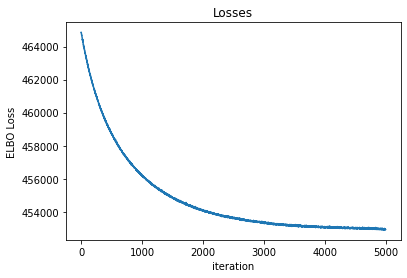

In [142]:
# Plot the loses
pseudo_time_reg_deconv.plot_loss()

In [143]:
pyro.get_param_store().keys()

dict_keys(['log_phi_posterior_loc_g', 'log_beta_posterior_loc_g', 'gp.f_loc', 'gp.f_scale_tril', 'f_posterior_loc_mc', 'gp.kernel.kern0.lengthscale', 'gp.kernel.kern0.variance', 'gp.kernel.kern1.variance', 'gp_f_mean_c'])

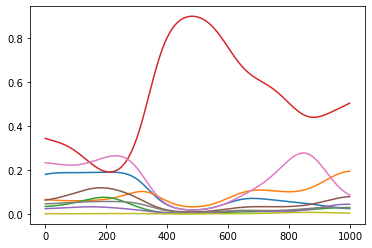

In [144]:
with torch.no_grad():
    traj = pseudo_time_reg_deconv.population_proportion_model
    xi_new_nq = torch.linspace(0., 1., 1000, device=device, dtype=dtype)[..., None]
    f_new_loc_cn, f_new_var_cn = traj.gp.forward(xi_new_nq, full_cov=False)
    f_new_scale_cn = f_new_var_cn.sqrt()
    pi_new_loc_cn = torch.softmax(f_new_loc_cn, dim=0)

plt.plot(pi_new_loc_cn.cpu().numpy().T)

## Plotting demo code

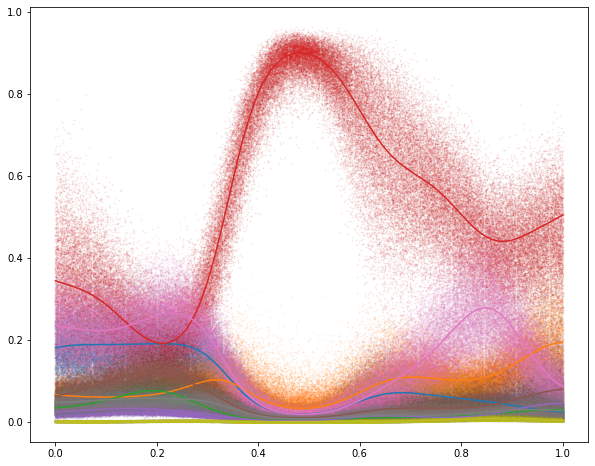

In [159]:
n_samples = 100
with torch.no_grad():
    traj = pseudo_time_reg_deconv.population_proportion_model
    xi_new_nq = torch.linspace(0., 1., 1000, device=device, dtype=dtype)[..., None]
    f_new_loc_cn, f_new_var_cn = traj.gp.forward(xi_new_nq, full_cov=False)
    f_new_scale_cn = f_new_var_cn.sqrt()
    f_new_sampled_scn = torch.distributions.Normal(f_new_loc_cn, f_new_scale_cn).sample([n_samples])
    pi_new_sampled_scn = torch.softmax(f_new_sampled_scn, dim=1)
    pi_new_loc_cn = torch.softmax(f_new_loc_cn, dim=0)

fig, ax = plt.subplots(figsize=(10, 8))

# plot the mean trajectory
ax.plot(
    xi_new_nq.cpu().numpy(),
    pi_new_loc_cn.cpu().numpy().T);

# plot samples
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i_cell_type in range(pi_new_loc_cn.shape[0]):
    color = colors[i_cell_type]
    ax.scatter(
        x=xi_new_nq.expand((n_samples,) + xi_new_nq.shape).cpu().numpy().flatten(),
        y=pi_new_sampled_scn[:, i_cell_type, :].cpu().numpy().flatten(),
        c=color,
        alpha=0.1,
        s=0.5)

In [91]:
# calculate and plot the composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

NotImplementedError: 

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

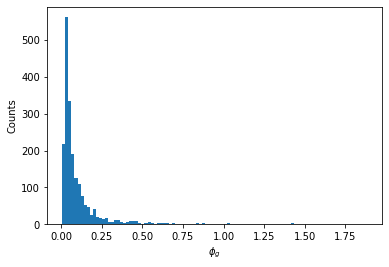

In [16]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

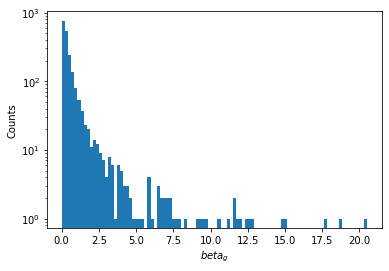

In [17]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'Last few Dirichlet $ \\alpha $ Values')

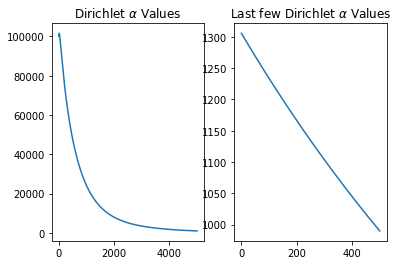

In [18]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')


In [92]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

KeyError: 'cell_pop_posterior_loc_mc'

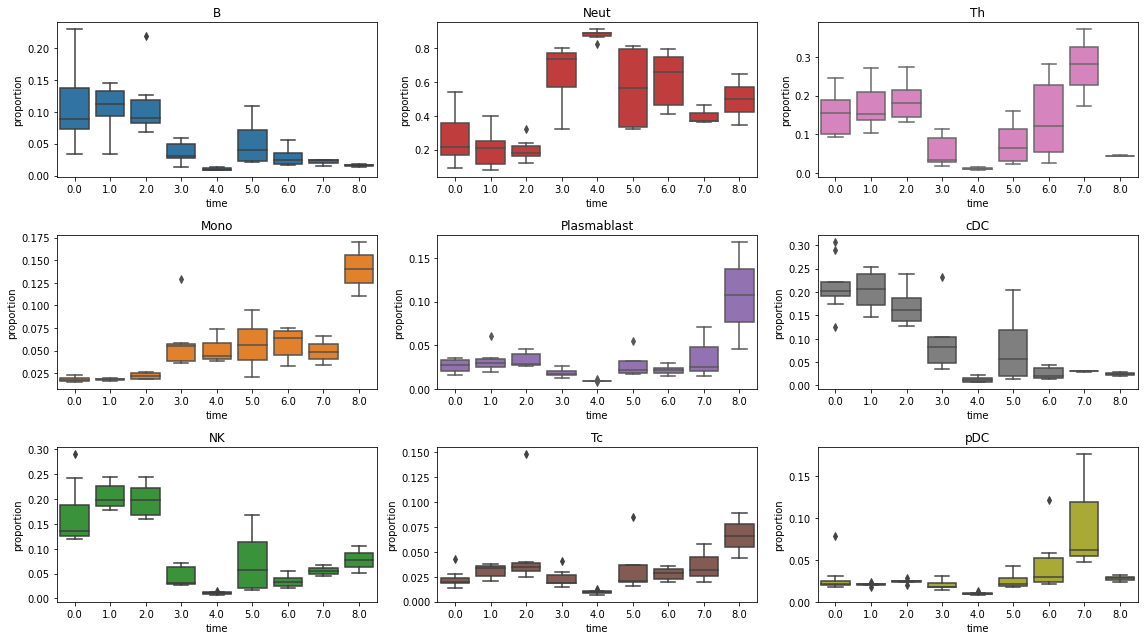

In [20]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()